## Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Handling Money and Sales, so money formatting is more appropriate for certain values
For this, I created a formatting method for currency.

In [2]:
def money_format(x):
    return "$"+('%.2f' % x).rstrip('0').rstrip('.')

Loading the dataframe from the csv/excel file into a variable called *data*.

## Reading in transactions data

In [3]:
data = pd.read_csv('datasets/shopify_data.csv')

***
I want to first verify that that there the entire dataframe is filled and NA/NaN values are not present.

For this, I use the *.info()* method on my dataframe

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
order_id          5000 non-null int64
shop_id           5000 non-null int64
user_id           5000 non-null int64
order_amount      5000 non-null int64
total_items       5000 non-null int64
payment_method    5000 non-null object
created_at        5000 non-null object
dtypes: int64(5), object(2)
memory usage: 273.5+ KB
None


***
# How did the wrong Average Order Value (AOV) value come into play?

In [5]:
print("Incorrect AOV:",money_format(data['order_amount'].mean()))

Incorrect AOV: $3145.13


***
## Moving Forward to get a more appropriate AOV...
First, lets confirm that there are indeed 100 different shops.

In [6]:
list_of_shops = data['shop_id'].unique()

Now, I will find the total number of items bought for the total amount of money paid. 
To do this, I will break each order into items and populate a list

In [7]:
list_of_items = []

for shop_id_num in list_of_shops:    
    #print(data[data["shop_id"] == shop_id_num][['order_amount','total_items']].sum())

    total_item_count = data[data["shop_id"] == shop_id_num]['total_items'].sum()
    average_cost = data[data["shop_id"] == shop_id_num]['order_amount'].sum()/total_item_count
    #print(average_cost)
    for x in range(total_item_count):
        list_of_items.append(average_cost)

In [8]:
#print(list_of_items)

In [9]:
print("Median cost per item:",money_format(np.median(np.array(list_of_items))))

Median cost per item: $352


In [10]:
print("Average cost per item based on total cost of all items:",money_format(np.mean(np.array(list_of_items))))

Average cost per item based on total cost of all items: $357.92


# Plotting my data to see how it looks

## Histogram of cost of each item purchased, regardless of how many transactions were required to acquire every pair of sneakers

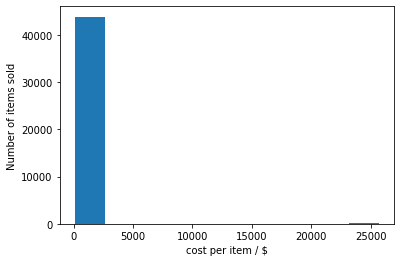

[   90.   2653.5  5217.   7780.5 10344.  12907.5 15471.  18034.5 20598.
 23161.5 25725. ]
[43848.     0.     0.     0.     0.     0.     0.     0.     0.    88.]


In [11]:
counts1, edges1, plot = plt.hist(np.array(list_of_items), bins = 10)
plt.xlabel('cost per item / $')
plt.ylabel('Number of items sold')
plt.show()
print(edges1)
print(counts1)

There is clearly something skewing this data, so I should look out for why we have such extremes in pricing.

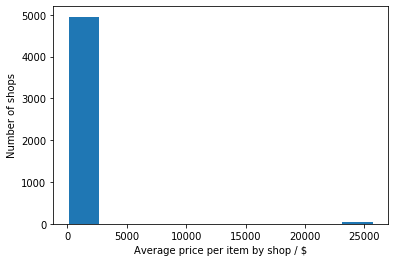

[   90.   2653.5  5217.   7780.5 10344.  12907.5 15471.  18034.5 20598.
 23161.5 25725. ]
1281.75
[4954.    0.    0.    0.    0.    0.    0.    0.    0.   46.]


In [12]:
#Finding values greater than the average. Average cost is greater than the median cost

data['average_cost_per_item'] = data['order_amount']/data['total_items']
data.sort_values(by = 'average_cost_per_item')
counts2, edges2, plot = plt.hist(data['average_cost_per_item'], bins = 10)
plt.xlabel('Average price per item by shop / $')
plt.ylabel('Number of shops')
plt.show()
print(edges2)
print((edges2[8]-edges2[7])/2)
print(counts2)

## Comparing the size of bins and count of each bin shows that the each transaction does not equate to a single item purchased
Bin edges align and confirm that all data is accounted for.

Count of each bin lines up for the middle, but not the extremes.

In [13]:
print(edges1 == edges2)

[ True  True  True  True  True  True  True  True  True  True  True]


In [14]:
print(counts1 == counts2)

[False  True  True  True  True  True  True  True  True False]


# THIS IS SHOWING THAT THERE IS A STORE OR A FEW STORES THAT ARE CHARGING A VERY HIGH PRICE FOR SNEAKERS ON AVERAGE
## 88 PAIRS OF SNEAKERS SOLD IN 46 TRANSACTIONS at the extreme of pricing (>$20000/pair), but 

***
This made me want to know what other "abnormalities" or unique parameters may exist.
First, I looked at the x-axis parameters from the above histograms.


In [15]:
print("Total Items:",data['total_items'].unique())
print("Unique Average Cost per Item:",data['average_cost_per_item'].unique())

Total Items: [   2    1    4    3    5    6 2000    8]
Unique Average Cost per Item: [  158.    94.   148.   128.   142.   187.   112.   132.   118.   184.
   201.   160.   116.   153.   156.   176.   163.   127.   146.   140.
   130.   169.   164.   129.   101.   173.   122.   190.   134.   161.
   352.   181.   144.   166.   145.   117.   193.   133.   171.   147.
   138.   178.   177.   136.   154.   131.   165.   155. 25725.   172.
   149.   196.    90.   114.   168.   162.   195.   111.]


***
Then I moved towards understanding the other columns.


In [16]:
print(data.nunique())

order_id                 5000
shop_id                   100
user_id                   301
order_amount              258
total_items                 8
payment_method              3
created_at               4702
average_cost_per_item      58
dtype: int64


In [17]:
data['transaction_time'] = pd.to_datetime(data['created_at']).dt.strftime('%m/%d/%Y %H:%M')


In [18]:
data['month'] = pd.to_datetime(data['created_at']).dt.strftime('%m/%Y')

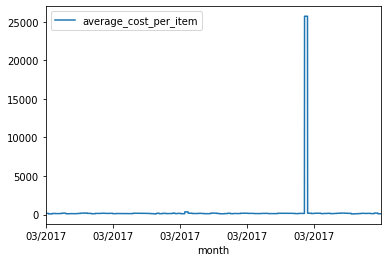

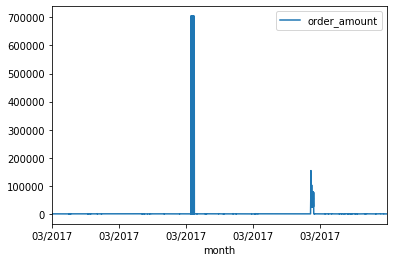

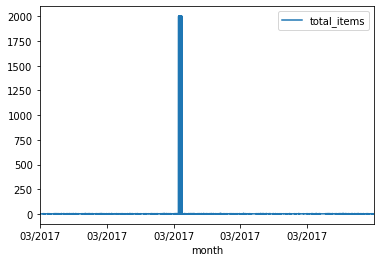

In [19]:
data.plot(kind = "line", x = 'month', y = 'average_cost_per_item')
data.plot(kind = "line", x = 'month', y = 'order_amount')
data.plot(kind = "line", x = 'month', y = 'total_items')
plt.show()


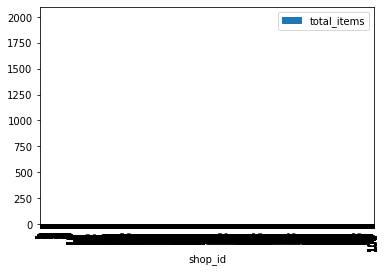

In [20]:
data.plot(kind = 'bar', x = 'shop_id', y = 'total_items')
plt.show()

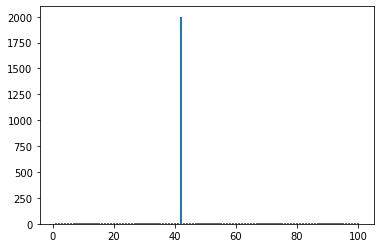

In [21]:
plt.bar(data['shop_id'],data['total_items'])
plt.show()

In [22]:
debit = data[data['payment_method'] == 'debit']
cash = data[data['payment_method'] == 'cash']
credit = data[data['payment_method'] == 'credit']

print(debit)


      order_id  shop_id  user_id  order_amount  total_items payment_method  \
0           42        1      847           316            2          debit   
7          729        1      847           316            2          debit   
8          933        1      805           316            2          debit   
10        1021        1      715           316            2          debit   
11        1168        1      738           158            1          debit   
12        1191        1      734           316            2          debit   
14        1378        1      889           158            1          debit   
15        1547        1      747           158            1          debit   
17        1825        1      705           474            3          debit   
19        2079        1      900           158            1          debit   
20        2194        1      798           474            3          debit   
21        2226        1      811           316            2     

TypeError: legend only accepts two non-keyword arguments

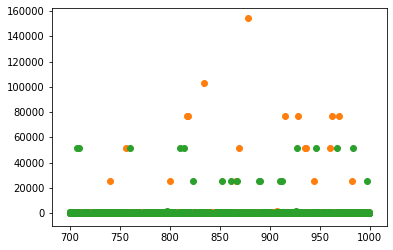

In [27]:
credit_pt = plt.scatter(credit['user_id'],credit['order_amount'])
debit_pt = plt.scatter(debit['user_id'],debit['order_amount'])
cash_pt = plt.scatter(cash['user_id'],cash['order_amount'])

plt.legend('credit','debit','cash')
plt.show()